In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

## Callback

In [24]:
class Callback(object):
    """Base class for all utility callbacks and CallbackHandler."""
    
    def on_train_begin(self): pass
    def on_epoch_begin(self): pass
    def on_batch_begin(self): pass
    
    def on_forward_end(self): pass  # yhatb is available for computing accuracy
    def on_loss_end(self): pass  # loss is available
    
    def on_batch_end(self): pass
    def on_epoch_end(self): pass
    def on_train_end(self): pass

## CallbackHandler

In [164]:
class CallbackHandler(Callback):
    
    def __init__(self, cbs): 
        self.cbs = cbs
        self.state_dict = {}
        for c in self.cbs:  # each child cb can see self.state_dict and its updated versions
            c.state_dict = self.state_dict
    
    def on_train_begin(self): 
        
        self.state_dict['epoch'] = -1
        
        for cb in self.cbs:
            cb.on_train_begin()
            
    def on_epoch_begin(self): 
        
        self.state_dict['epoch'] += 1
        self.state_dict['iteration'] = -1
        
        for cb in self.cbs:
            cb.on_epoch_begin()
            
    def on_batch_begin(self, **kwargs):
        
        self.state_dict['batch_index'] += 1
        
        self.state_dict['yb'] = kwargs['yb']  # for computing accuracy
        self.state_dict['bs'] = kwargs['bs']  # for computing any metric
        
        for cb in self.cbs:
            cb.on_batch_begin()
            
    def on_forward_end(self, **kwargs):
        
        self.state_dict['yhatb'] = kwargs['yhatb']  # for computing accuracy
        
        for cb in self.cbs:
            cb.on_forward_end()
            
    def on_loss_end(self, **kwargs): 
        
        self.state_dict['lossb'] = kwargs['lossb']  # for computing loss
        
        for cb in self.cbs:
            cb.on_loss_end()
            
    def on_batch_end(self): 
        for cb in self.cbs:
            cb.on_batch_end()
            
    def on_epoch_end(self): 
        for cb in self.cbs:
            cb.on_epoch_end()
            
    def on_train_end(self): 
        for cb in self.cbs:
            cb.on_train_end()

## Utility callbacks

In [5]:
class LossCallback(Callback):
    
    def on_train_begin(self):
        self.state_dict['losses'] = []
        
    def on_epoch_begin(self):
        self.weighted_values = []
        self.num_examples = 0
        
    def on_loss_end(self):
        self.weighted_values.append(self.state_dict['lossb'] * self.state_dict['bs'])
        self.num_examples += self.state_dict['bs']
        
    def on_epoch_end(self):
        self.state_dict['losses'].append(np.sum(self.weighted_values) / self.num_examples)

NameError: name 'Callback' is not defined

## Learner

In [166]:
class Learner():
    
    def __init__(self, train_dl, test_dl, model, loss, optim):
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.model = model
        self.loss = loss
        self.optim = optim

## Trainer

In [167]:
class Trainer:
    
    def __init__(self, learn, cb_handler):
        self.learn = learn
        self.cb_handler = cb_handler
        
    def train(self, num_epoch=10):
        
        self.cb_handler.on_train_begin()
    
        for epoch in tqdm_notebook(range(num_epoch)):

            self.cb_handler.on_epoch_begin()

            # ========== train ==========

            self.learn.model.train()
            for xb, yb in self.learn.train_dl:

                yhatb = model(xb.float())
                lossb = self.learn.loss(yhatb, yb.float())

                lossb.backward()
                self.learn.opt.step()
                self.learn.opt.zero_grad()

            # ========== validation ==========

            self.learn.model.eval()
            for xb, yb in self.learn.valid_dl:
                
                self.cb_handler.on_batch_begin(yb=yb, bs=yb.size(0))
                
                yhatb = self.learn.model(xb.float())
                self.cb_handler.on_forward_end(yhatb=yhatb)
                
                lossb = self.learn.loss(yhatb, yb.float())
                self.cb_handler.on_loss_end(lossb=lossb)
                
                self.cb_handler.on_batch_end()
                
            self.cb_handler.on_epoch_end()
            
        self.cb_handler.on_train_end()

## Prepare data and train

In [172]:
df = pd.read_csv('circuluar_data.csv')
df.head()

,x,y,Class
0,0.474727,0.196585,C1
1,0.472605,0.131267,C1
2,0.454771,0.231433,C1
3,0.466462,0.259099,C1
4,0.380472,0.216625,C1


In [173]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']].convert_objects(convert_numeric=True).to_numpy()

In [174]:
labels = df['Class'].to_numpy()
labels[np.where(labels == 'C1')[0]] = 0
labels[np.where(labels == 'C2')[0]] = 1
labels = labels.astype(int)

In [175]:
examples.shape, labels.shape

((692, 2), (692,))

In [176]:
def train_test_split(examples, labels, prop_valid=0.4, seed=42):
    
    num_train = int(np.floor(len(examples) * (1 - prop_valid)))
    idxs = np.arange(len(examples))
    
    np.random.seed(seed)
    np.random.shuffle(idxs)
    
    train_idxs, valid_idxs = idxs[:num_train], idxs[num_train:]
    
    return (examples[train_idxs], labels[train_idxs]), (examples[valid_idxs], labels[valid_idxs])

In [177]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(examples, labels)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((415, 2), (415,), (277, 2), (277,))

In [178]:
X, Y = np.s_[:,0], np.s_[:,1]

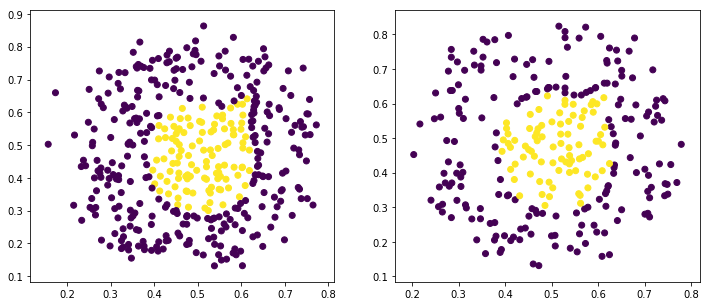

In [179]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.scatter(x_train[X], x_train[Y], c=y_train)

fig.add_subplot(122)

plt.scatter(x_valid[X], x_valid[Y], c=y_valid)
plt.show()

In [1]:
train_ds = TD(T(x_train), T(y_train))
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_valid), T(y_valid))
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

NameError: name 'TD' is not defined

In [ ]:
class NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1)
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb

In [ ]:
def get_model():
    nn = NN()
    return nn, opt.Adam(nn.parameters())

In [4]:
model, optim = get_model()
loss = nn.BCELoss()
learn = Learner(train_dl, valid_dl, model, loss, optim)

cb_handler = CallbackHandler(cbs=[LossCallback()])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

NameError: name 'get_model' is not defined

In [3]:
trainer.train()

NameError: name 'trainer' is not defined